# Ідея

1. Основна ідея полягає у старій легенді, що за закриттям фондового ринку в п'ятницю ввечері. Можна брати (купувати) загальний EТФ світової економіки тобто SPY і по події вихідних коли він зробить геп фіксувати його в понеділок вранці.

2. Ідеї додаткові, на перевірку:
  - Перевірити цю структуру за іншими днями тижня
  - якщо є хороша статистика, спроектувати на інші акції.

S&P 500 (укр. Ес енд Пі 500) — фондовий індекс, у кошик якого включено 500 акціонерних компаній США, що мають найбільшу капіталізацію. Список належить компанії Standard & Poor's і нею ж складається. Вперше був розрахований 4 березня 1957 року. Станом на 30 червня 2023 року дев’ять найбільших компаній у списку компаній S&P 500 становили 30,5% ринкової капіталізації індексу: Apple, Microsoft, Amazon, Nvidia, Alphabet, Tesla, Meta, Berkshire Hathaway і UnitedHealth Group.

Індекс є одним з факторів у розрахунку провідного економічного індексу Conference Board, який використовується для прогнозування напрямку розвитку економіки.

# Збір та обробка данних

In [87]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns

In [88]:
file_path = r'D:\Users\Artem\Desktop\аналитика\занятия\proekt3\SPY.csv'
data = pd.read_csv(file_path)
print(data.head(5))
print(data.tail(5))

         Date        Open        High         Low       Close   Adj Close  \
0  2020-09-08  336.709991  342.640015  332.880005  333.209991  317.396423   
1  2020-09-09  337.549988  342.459991  336.609985  339.790009  323.664124   
2  2020-09-10  341.820007  342.529999  332.850006  333.890015  318.044159   
3  2020-09-11  335.820007  336.970001  331.000000  334.059998  318.205994   
4  2020-09-14  337.489990  340.380005  334.220001  338.459991  322.397247   

      Volume  
0  114465300  
1   91462300  
2   90569500  
3   84680200  
4   65605700  
           Date        Open        High         Low       Close   Adj Close  \
792  2023-10-31  416.179993  418.529999  414.209991  418.200012  418.200012   
793  2023-11-01  419.200012  423.500000  418.649994  422.660004  422.660004   
794  2023-11-02  426.579987  430.920013  426.559998  430.760010  430.760010   
795  2023-11-03  433.140015  436.290009  433.010010  434.690002  434.690002   
796  2023-11-06  435.470001  436.149994  433.679993 

In [89]:
SPY_data = data.drop(['Low', 'High', 'Adj Close'], axis=1)
SPY_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    797 non-null    object 
 1   Open    797 non-null    float64
 2   Close   797 non-null    float64
 3   Volume  797 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 25.0+ KB


In [90]:
duplicate_rows = SPY_data[SPY_data.duplicated()]
print("\nДубликати:")
print(duplicate_rows)


Дубликати:
Empty DataFrame
Columns: [Date, Open, Close, Volume]
Index: []


In [91]:
missing_values = SPY_data.isnull().sum()
print("Пусті значення в кожному стовпці:")
print(missing_values)

Пусті значення в кожному стовпці:
Date      0
Open      0
Close     0
Volume    0
dtype: int64


In [92]:
unique_indexes = SPY_data.index.nunique()
print("Кількість уникальних индексів:", unique_indexes)

Кількість уникальних индексів: 797


# Статистичний аналіз даних та візуалізація

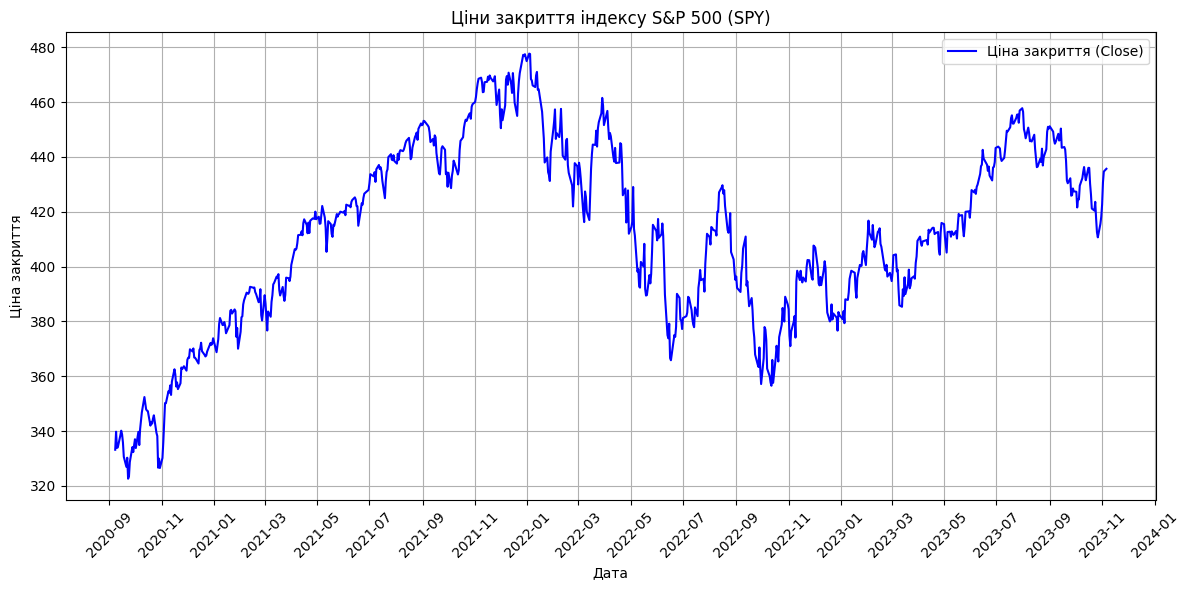

In [93]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Побудова графіка цін закриття індексу S&P 500
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Ціна закриття (Close)', color='b')
plt.title('Ціни закриття індексу S&P 500 (SPY)')
plt.xlabel('Дата')
plt.ylabel('Ціна закриття')
plt.legend()
plt.grid()

# Форматуємо ось x для відображення місяців щомісяця
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)  # Повертаємо підписи на осі x для зручності читання

plt.tight_layout()
plt.show()

### Створюємо один із найважливіших стовпців Percent Change - різниця між закриттям та відкриттям у відсотках

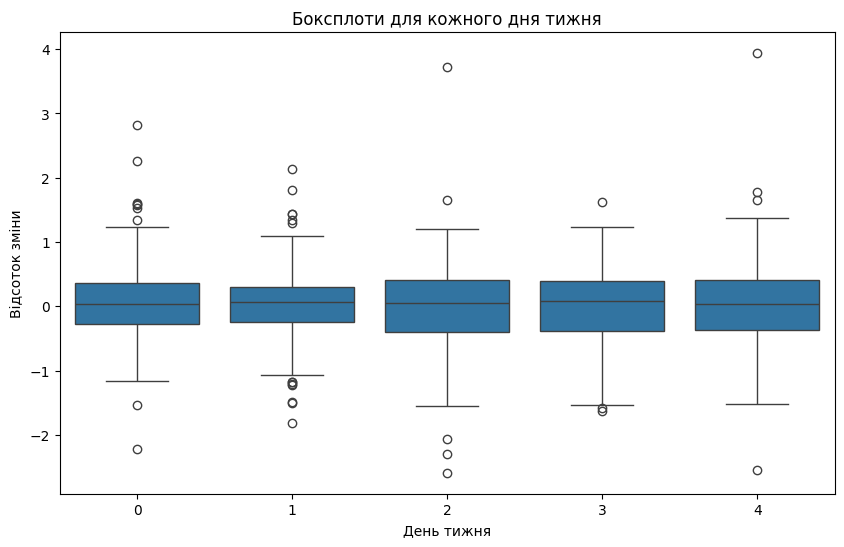

In [94]:
SPY_data['Percent Change'] = ((SPY_data['Open'].shift(-1) - SPY_data['Close']) / SPY_data['Close'] * 100).round(3)
SPY_data['Date'] = pd.to_datetime(SPY_data['Date'])

SPY_data['Day of Week'] = SPY_data['Date'].dt.dayofweek

plt.figure(figsize=(10, 6))
sns.boxplot(x='Day of Week', y='Percent Change', data=SPY_data)
plt.title('Боксплоти для кожного дня тижня')
plt.xlabel('День тижня')
plt.ylabel('Відсоток зміни')
plt.show()

#### Коригуємо боксплоти без викідів

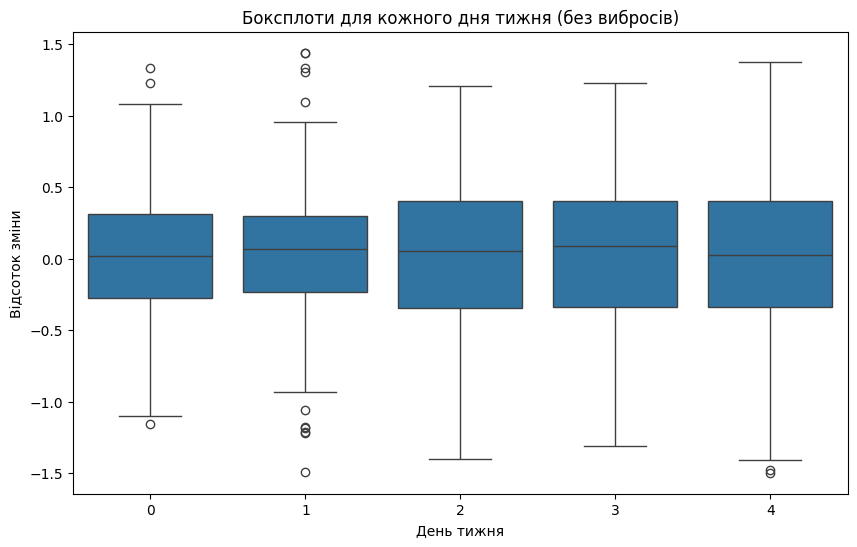

In [95]:
lower_bound = -1.5
upper_bound = 1.5

# Фильтруем данные, оставляя только значения в заданных пределах
filtered_data = SPY_data[(SPY_data['Percent Change'] >= lower_bound) & (SPY_data['Percent Change'] <= upper_bound)]

# Строим боксплоты для отфильтрованных данных
plt.figure(figsize=(10, 6))
sns.boxplot(x='Day of Week', y='Percent Change', data=filtered_data)
plt.title('Боксплоти для кожного дня тижня (без вибросів)')
plt.xlabel('День тижня')
plt.ylabel('Відсоток зміни')
plt.show()

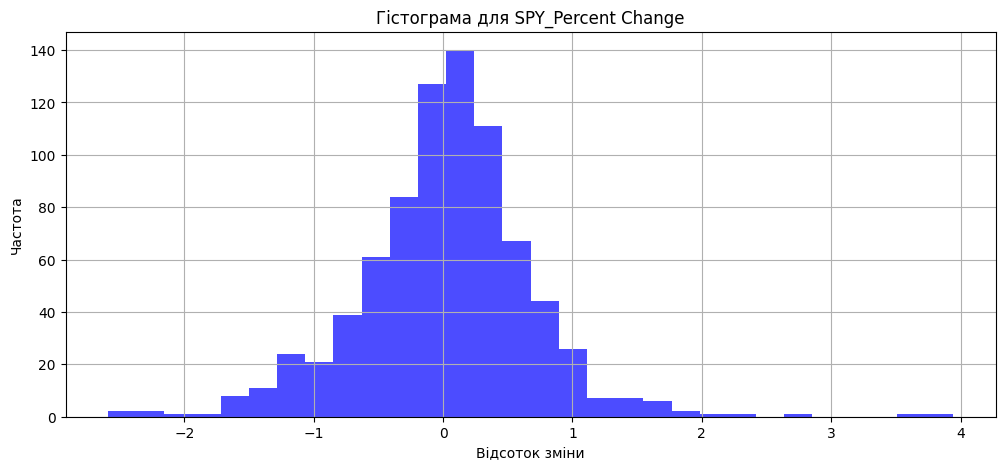

In [96]:
plt.figure(figsize=(12, 5))
plt.hist(SPY_data['Percent Change'], bins=30, color='blue', alpha=0.7)
plt.title('Гістограма для SPY_Percent Change')
plt.xlabel('Відсоток зміни')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

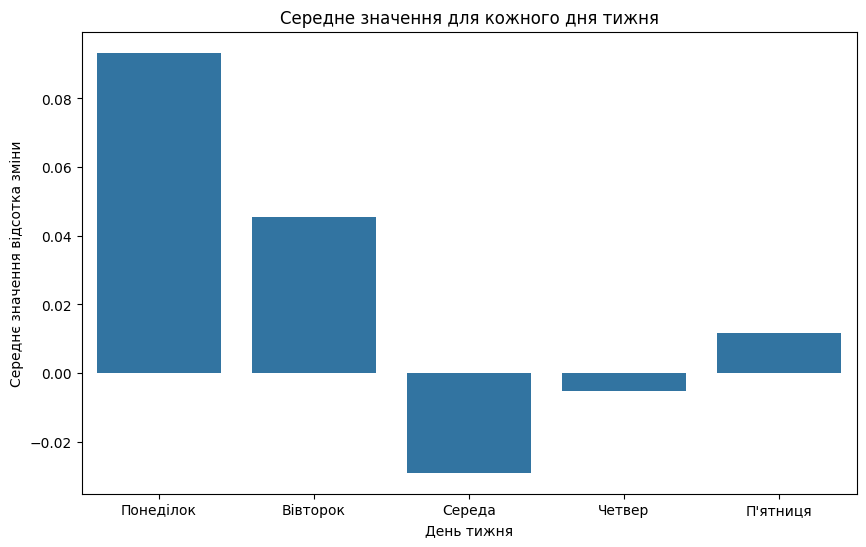

In [97]:
day_mapping = {0: 'Понеділок', 1: 'Вівторок', 2: 'Середа', 3: 'Четвер', 4: 'П\'ятниця'}
mean_by_day = SPY_data.groupby('Day of Week')['Percent Change'].mean()

# Строим барплот
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_by_day.index.map(day_mapping), y=mean_by_day.values)
plt.title('Середне значення для кожного дня тижня')
plt.xlabel('День тижня')
plt.ylabel('Середнє значення відсотка зміни')
plt.show()

In [98]:
mean_by_day = SPY_data.groupby('Day of Week')['Percent Change'].mean()
print("Середнє значення для кожного дня тижня:")
print(mean_by_day)
count_by_day = SPY_data['Day of Week'].value_counts()
print("Кількість понеділків:", count_by_day[0])

Середнє значення для кожного дня тижня:
Day of Week
0    0.093322
1    0.045543
2   -0.029012
3   -0.005068
4    0.011692
Name: Percent Change, dtype: float64
Кількість понеділків: 147


In [99]:
SPY_data.describe()

,Date,Open,Close,Volume,Percent Change,Day of Week
count,797,797.000000,797.000000,7.970000e+02,796.000000,797.000000
mean,2022-04-07 06:35:41.028858112,411.858068,411.913275,8.280027e+07,0.021790,2.027604
min,2020-09-08 00:00:00,321.220001,322.640015,2.645790e+07,-2.590000,0.000000
25%,2021-06-23 00:00:00,389.369995,389.500000,6.241590e+07,-0.328000,1.000000
50%,2022-04-06 00:00:00,413.549988,413.940002,7.727490e+07,0.052000,2.000000
75%,2023-01-23 00:00:00,438.679993,438.640015,9.663130e+07,0.388250,3.000000
max,2023-11-06 00:00:00,479.220001,477.709991,2.517839e+08,3.944000,4.000000
std,NaN,33.692376,33.711122,2.891501e+07,0.666131,1.395161


In [100]:
SPY_data.to_csv(r'D:\Users\Artem\Desktop\аналитика\занятия\SPY_data_with_changes.csv', index=False)

## Короткі висновки
- Перевірка ідеї відкривати позиції на ринку у п'ятницю ввечері та закривати їх у понеділок не виправдала себе повністю.
- Але, виявилося, що ця ідея працює від понеділка до вівторка. Середній результат становить 0.093 за 147 понеділків, що значно краще за середній результат в 0.0218, майже в 4 рази.
- Спробуємо застосувати цю стратегію до топ-7 акцій для досягнення більш виразного ефекту.

<br>
<br>
<br>
<br>

# Обробляємо нові данні

### за акціями AAPL, AMZN, GOOG, META, MSFT, NVDA, TSLA

In [101]:
data_folder = r'D:\Users\Artem\Desktop\аналитика\занятия\proekt3'

files = os.listdir(data_folder)
tickers = [file.split('.')[0] for file in files if file.endswith('.csv')]
print("Список акцій:", tickers)

dfs = [pd.read_csv(os.path.join(data_folder, f'{ticker}.csv'))[['Open', 'Close']].rename(columns={'Open': f'{ticker}_Open', 'Close': f'{ticker}_Close'}) for ticker in tickers]
all_data = pd.concat(dfs, axis=1)
spy_date = pd.read_csv(os.path.join(data_folder, 'SPY.csv'))['Date']
all_data.insert(0, 'Date', pd.to_datetime(spy_date))
print("Об'єднані дані:")
print(all_data.head())

Список акцій: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
Об'єднані дані:
        Date   AAPL_Open  AAPL_Close   AMZN_Open  AMZN_Close  GOOG_Open  \
0 2020-09-08  113.949997  112.820000  157.199997  157.492004  76.675499   
1 2020-09-09  117.260002  117.320000  160.149506  163.430496  77.876503   
2 2020-09-10  120.360001  113.489998  165.360992  158.755493  78.031998   
3 2020-09-11  114.570000  112.000000  160.434494  155.811005  76.800003   
4 2020-09-14  114.720001  115.360001  158.647003  155.148499  76.950249   

   GOOG_Close   META_Open  META_Close   MSFT_Open  MSFT_Close   NVDA_Open  \
0   76.619499  271.279999  271.160004  206.500000  202.660004  117.345001   
1   77.848000  275.769989  273.720001  207.600006  211.289993  124.000000   
2   76.600998  275.510010  268.089996  213.399994  205.369995  129.892502   
3   76.036003  270.059998  266.609985  207.199997  204.029999  124.855003   
4   75.963997  270.950012  266.149994  204.240005  205.410004  130.809

In [102]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        797 non-null    datetime64[ns]
 1   AAPL_Open   797 non-null    float64       
 2   AAPL_Close  797 non-null    float64       
 3   AMZN_Open   797 non-null    float64       
 4   AMZN_Close  797 non-null    float64       
 5   GOOG_Open   797 non-null    float64       
 6   GOOG_Close  797 non-null    float64       
 7   META_Open   797 non-null    float64       
 8   META_Close  797 non-null    float64       
 9   MSFT_Open   797 non-null    float64       
 10  MSFT_Close  797 non-null    float64       
 11  NVDA_Open   797 non-null    float64       
 12  NVDA_Close  797 non-null    float64       
 13  SPY_Open    797 non-null    float64       
 14  SPY_Close   797 non-null    float64       
 15  TSLA_Open   797 non-null    float64       
 16  TSLA_Close  797 non-null  

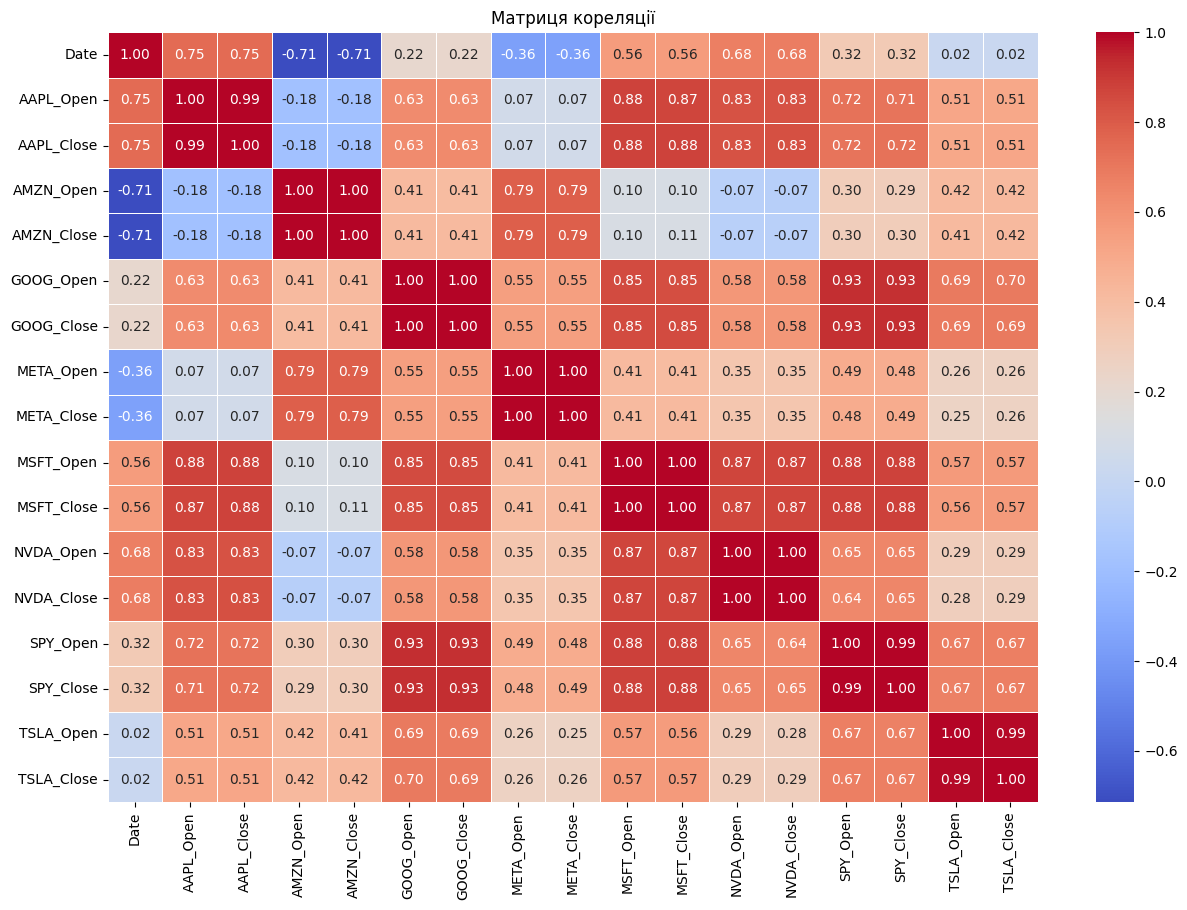

In [103]:
correlation_matrix = all_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Матриця кореляції')
plt.show()

### По матриці кореляції можна сказати, що
   1. #### Кореляцію можно рахувати як по закриттю, так і відкриттю. Також можливо і по любій точці в довільний проміжок часу
   2. ####  SPY має високу кореляцію з MSFT & GOOG і досить гарну з APPL, NVDA та TSLA. Спробуємо на ці акції більш детально привернути увагу

In [104]:
for ticker in tickers:
    all_data[f'{ticker}_Percent Change'] = ((all_data[f'{ticker}_Open'].shift(-1) - all_data[f'{ticker}_Close']) / all_data[f'{ticker}_Close'] * 100).round(3)
    print(all_data[[f'{ticker}_Open', f'{ticker}_Close', f'{ticker}_Percent Change']].head(-5))
    all_data[[f'{ticker}_Open', f'{ticker}_Close', f'{ticker}_Percent Change']].to_csv(f'{ticker}_data_with_changes.csv', index=False)

      AAPL_Open  AAPL_Close  AAPL_Percent Change
0    113.949997  112.820000                3.935
1    117.260002  117.320000                2.591
2    120.360001  113.489998                0.952
3    114.570000  112.000000                2.429
4    114.720001  115.360001                2.575
..          ...         ...                  ...
787  173.050003  173.440002               -0.899
788  171.880005  171.100006               -0.427
789  170.369995  166.889999                0.012
790  166.910004  168.220001                0.476
791  169.020004  170.289993               -0.552

[792 rows x 3 columns]
      AMZN_Open  AMZN_Close  AMZN_Percent Change
0    157.199997  157.492004                1.687
1    160.149506  163.430496                1.181
2    165.360992  158.755493                1.058
3    160.434494  155.811005                1.820
4    158.647003  155.148499                1.070
..          ...         ...                  ...
787  127.739998  128.559998               -1.

In [105]:
missing_values = all_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
all_data_cleaned = all_data.dropna()
print(all_data_cleaned.head(-5))

          Date   AAPL_Open  AAPL_Close   AMZN_Open  AMZN_Close   GOOG_Open  \
0   2020-09-08  113.949997  112.820000  157.199997  157.492004   76.675499   
1   2020-09-09  117.260002  117.320000  160.149506  163.430496   77.876503   
2   2020-09-10  120.360001  113.489998  165.360992  158.755493   78.031998   
3   2020-09-11  114.570000  112.000000  160.434494  155.811005   76.800003   
4   2020-09-14  114.720001  115.360001  158.647003  155.148499   76.950249   
..         ...         ...         ...         ...         ...         ...   
786 2023-10-23  170.910004  173.000000  124.629997  126.559998  136.229996   
787 2023-10-24  173.050003  173.440002  127.739998  128.559998  139.160004   
788 2023-10-25  171.880005  171.100006  126.040001  121.389999  129.770004   
789 2023-10-26  170.369995  166.889999  120.629997  119.570000  124.470001   
790 2023-10-27  166.910004  168.220001  126.199997  127.739998  124.029999   

     GOOG_Close   META_Open  META_Close   MSFT_Open  ...   TSLA

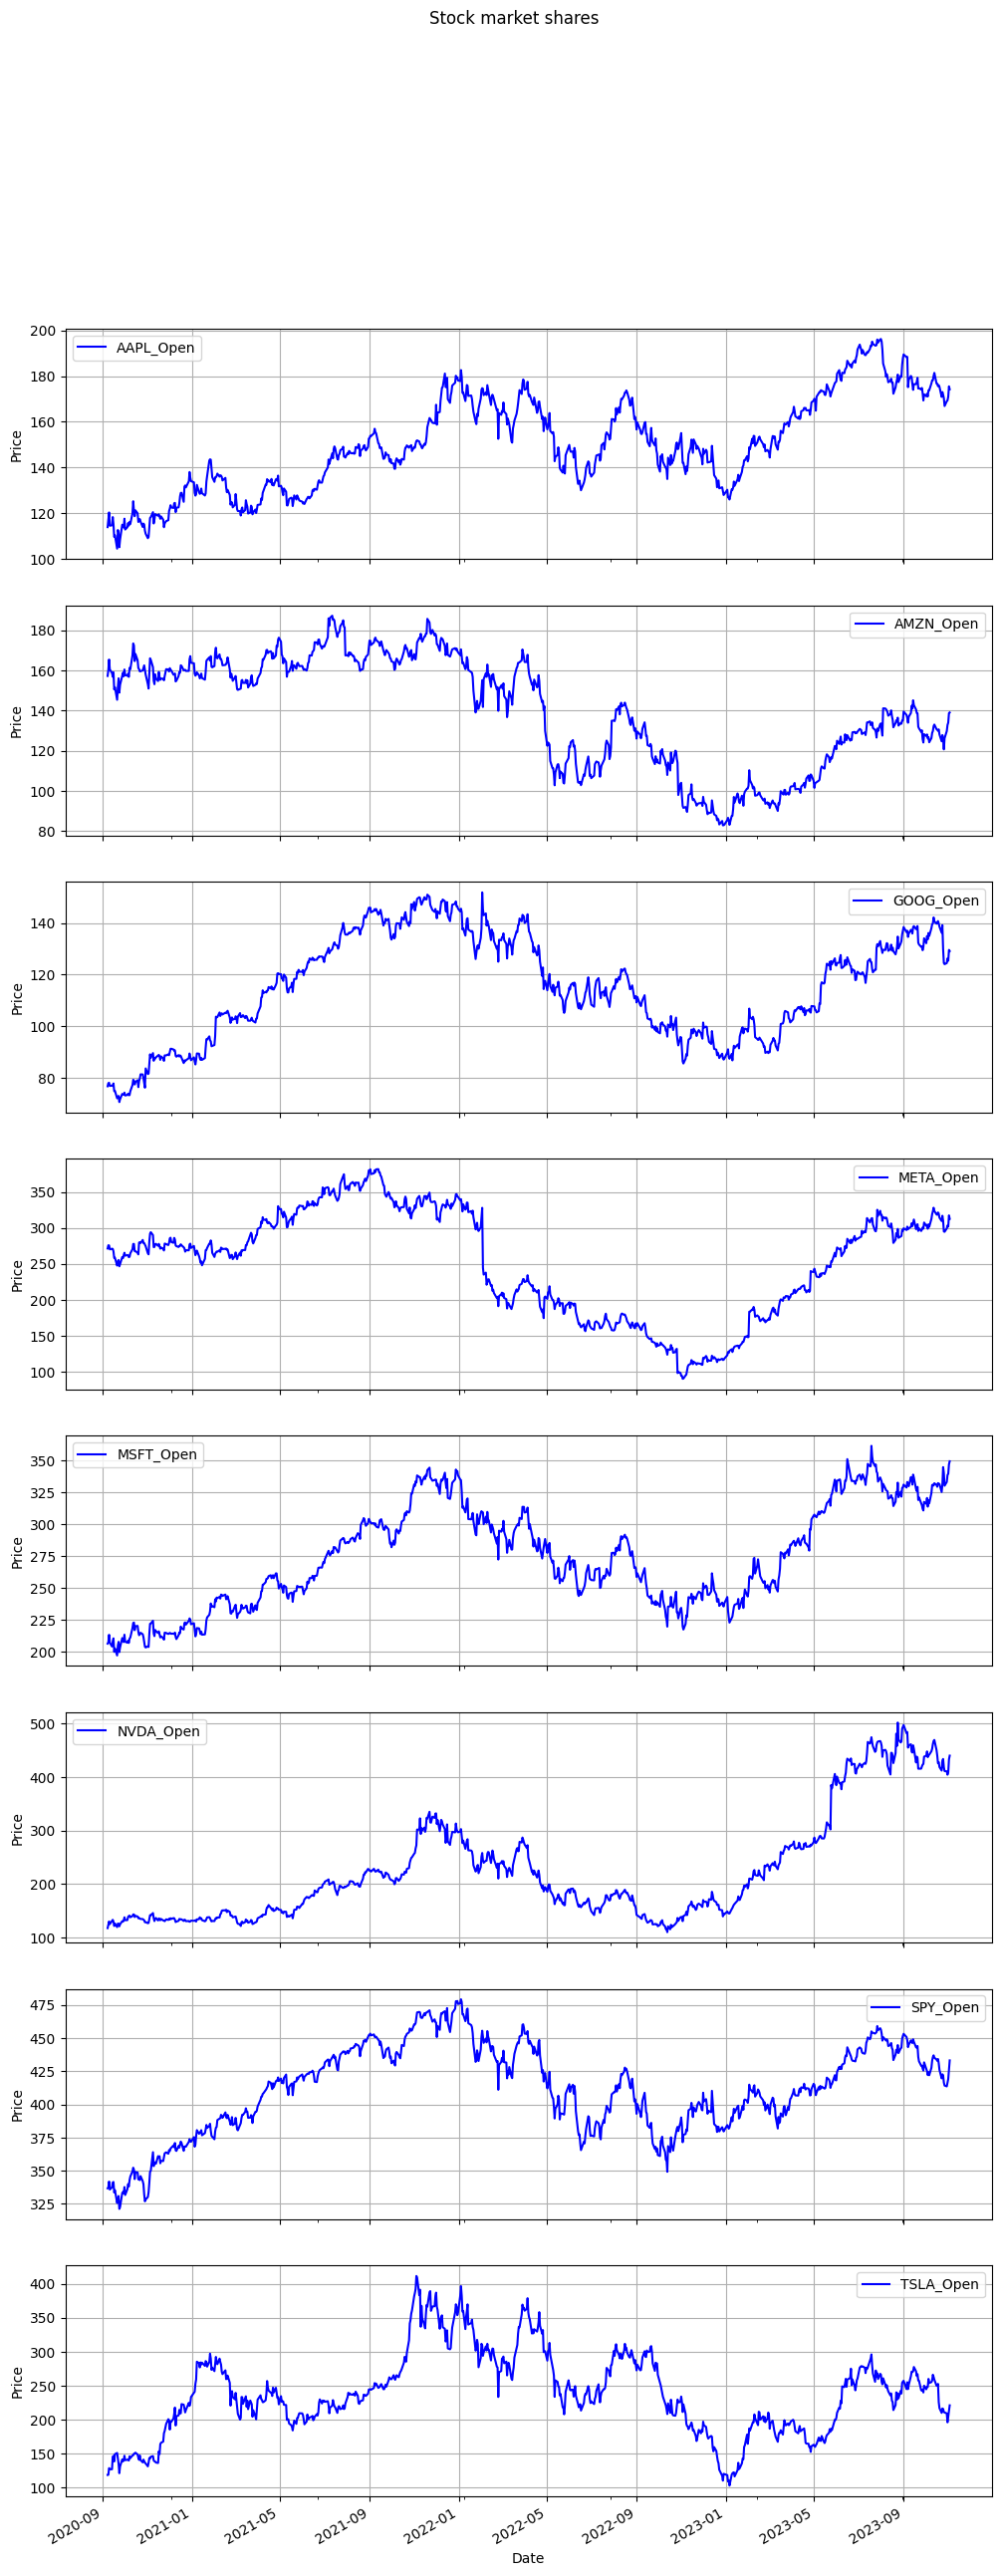

In [106]:
stock_indices = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

fig, axes = plt.subplots(nrows=len(stock_indices), ncols=1, figsize=(12, 4 * len(stock_indices)), sharex=True)

for i, stock in enumerate(stock_indices):
    stock_open_data = all_data_cleaned[['Date', f'{stock}_Open']]
    
    stock_open_data = stock_open_data.assign(Date=pd.to_datetime(stock_open_data['Date']))
    
    stock_open_data.set_index('Date', inplace=True)
    
    stock_open_data.plot(ax=axes[i], label=f'{stock} Open', color='b')
    
    axes[i].legend()
    
    axes[i].grid(True)
    
    axes[i].set_ylabel('Price')

plt.suptitle('Stock market shares')

plt.grid(True)

plt.show()

In [107]:
pd.options.mode.chained_assignment = None
all_data_cleaned['Date'] = pd.to_datetime(all_data_cleaned['Date'])

all_data_cleaned.loc[:, 'Weekday'] = all_data_cleaned['Date'].dt.day_name()

grouped_data = all_data_cleaned.groupby('Weekday').agg({
    'AAPL_Percent Change': ['max', 'mean'],
    'AMZN_Percent Change': ['max', 'mean'],
    'GOOG_Percent Change': ['max', 'mean'],
    'META_Percent Change': ['max', 'mean'],
    'MSFT_Percent Change': ['max', 'mean'],
    'NVDA_Percent Change': ['max', 'mean'],
    'SPY_Percent Change': ['max', 'mean'],
    'TSLA_Percent Change': ['max', 'mean']
})

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

grouped_data_sorted = grouped_data.reindex(weekday_order)

print(grouped_data_sorted)

          AAPL_Percent Change           AMZN_Percent Change            \
                          max      mean                 max      mean   
Weekday                                                                 
Monday                  3.467  0.163658               5.168  0.148199   
Tuesday                 3.935  0.015988               3.678  0.093512   
Wednesday               4.723 -0.091800               7.894  0.077655   
Thursday                4.076 -0.048778              12.072  0.026963   
Friday                  2.876 -0.081572               3.003 -0.022214   

          GOOG_Percent Change           META_Percent Change            \
                          max      mean                 max      mean   
Weekday                                                                 
Monday                  4.820  0.085089               6.468  0.057144   
Tuesday                10.143  0.104110               6.306  0.083098   
Wednesday               5.652  0.021673           

In [108]:
all_data_cleaned.describe()

,Date,AAPL_Open,AAPL_Close,AMZN_Open,AMZN_Close,GOOG_Open,GOOG_Close,META_Open,META_Close,MSFT_Open,...,TSLA_Open,TSLA_Close,AAPL_Percent Change,AMZN_Percent Change,GOOG_Percent Change,META_Percent Change,MSFT_Percent Change,NVDA_Percent Change,SPY_Percent Change,TSLA_Percent Change
count,796,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,...,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000
mean,2022-04-06 13:10:33.165828864,150.480390,150.599158,140.030170,139.922647,115.417603,115.488951,252.134447,252.196055,274.605691,...,238.880415,238.746156,-0.011938,0.063595,0.004293,-0.006048,0.045523,0.121275,0.021790,0.146636
min,2020-09-08 00:00:00,104.540001,106.839996,82.800003,81.820000,70.551498,70.760498,90.080002,88.910004,197.190002,...,103.000000,108.099998,-4.679000,-11.761000,-7.786000,-24.526000,-7.775000,-7.831000,-2.590000,-8.331000
25%,2021-06-22 18:00:00,134.237495,134.155003,116.030001,116.225000,99.542502,99.967501,189.750000,188.715003,242.620003,...,199.192501,197.792500,-0.535250,-0.483500,-0.495000,-0.745500,-0.459500,-0.888000,-0.328000,-1.023500
50%,2022-04-05 12:00:00,148.955002,149.125000,145.384247,145.187256,116.024250,116.519001,269.110001,268.254989,272.745010,...,235.688332,236.318329,0.023000,0.075500,0.009000,0.019000,0.053000,0.101000,0.052000,0.179500
75%,2023-01-20 18:00:00,168.475002,167.637505,163.749622,163.465497,133.010494,133.150006,313.557488,313.037491,307.817505,...,277.277504,276.017510,0.499500,0.607750,0.526500,0.678000,0.528000,0.972750,0.388250,1.190000
max,2023-11-03 00:00:00,196.240005,196.449997,187.199997,186.570496,151.863495,150.709000,381.679993,382.179993,361.750000,...,411.470001,409.970001,4.723000,12.072000,10.143000,19.762000,7.726000,26.148000,3.944000,12.762000
std,NaN,20.696489,20.768064,27.474286,27.396843,20.155527,20.094315,74.419886,74.315189,40.035844,...,60.819294,60.610903,1.033908,1.517243,1.253892,2.118814,1.064404,2.001358,0.666131,2.199195


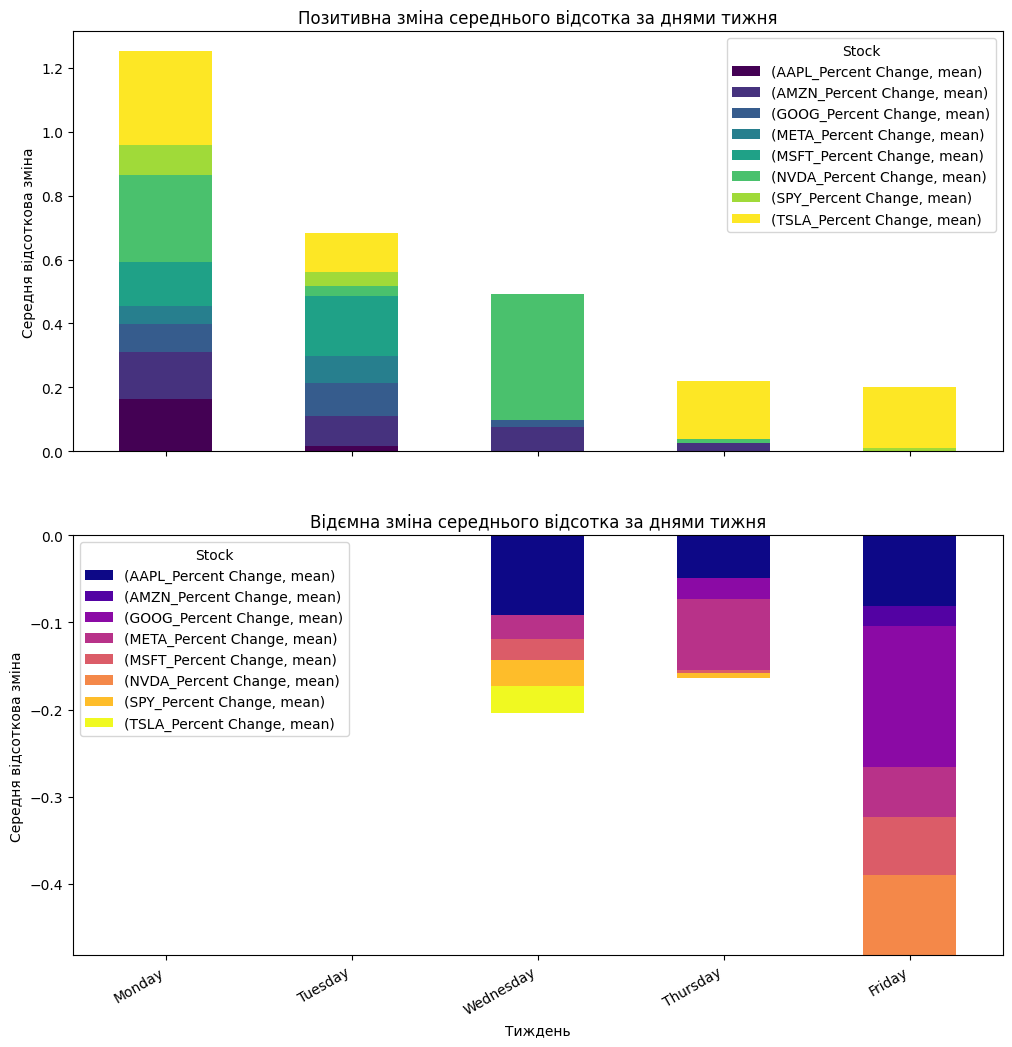

In [109]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

grouped_data_sorted = grouped_data.loc[weekday_order]

positive_data = grouped_data_sorted[grouped_data_sorted >= 0].fillna(0)
positive_data_mean = positive_data[[(stock, 'mean') for stock in positive_data.columns.levels[0]]]
positive_data_mean.plot(kind='bar', stacked=True, ax=axs[0], colormap='viridis')

axs[0].set_title('Позитивна зміна середнього відсотка за днями тижня')
axs[0].set_ylabel('Середня відсоткова зміна')
axs[0].legend(loc='upper right', title='Stock')

negative_data = grouped_data_sorted[grouped_data_sorted < 0].fillna(0)
negative_data_mean = negative_data[[(stock, 'mean') for stock in negative_data.columns.levels[0]]]
negative_data_mean.plot(kind='bar', stacked=True, ax=axs[1], colormap='plasma')

axs[1].set_title('Відємна зміна середнього відсотка за днями тижня')
axs[1].set_xlabel('Тиждень')
axs[1].set_ylabel('Середня відсоткова зміна')
axs[1].legend(loc='upper left', title='Stock')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, ha='right')

plt.show()

<br>
<br>
<br>
<br>

# Побудова прогнозної моделі на основі алгоритмів машинного навчання

In [110]:
features = ['AAPL_Open', 'AAPL_Close', 'GOOG_Open', 'GOOG_Close', 'META_Open', 'META_Close', 'MSFT_Open', 'MSFT_Close', 'NVDA_Open', 'NVDA_Close', 'TSLA_Open', 'TSLA_Close']
target = 'SPY_Percent Change'

train_data, test_data = train_test_split(all_data_cleaned, test_size=0.2, shuffle=False)

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.22104686568517568


In [111]:
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
tree_predictions = tree_model.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_predictions)
print(f'Mean Squared Error for Decision Tree: {tree_mse}')

Mean Squared Error for Decision Tree: 0.49884108125


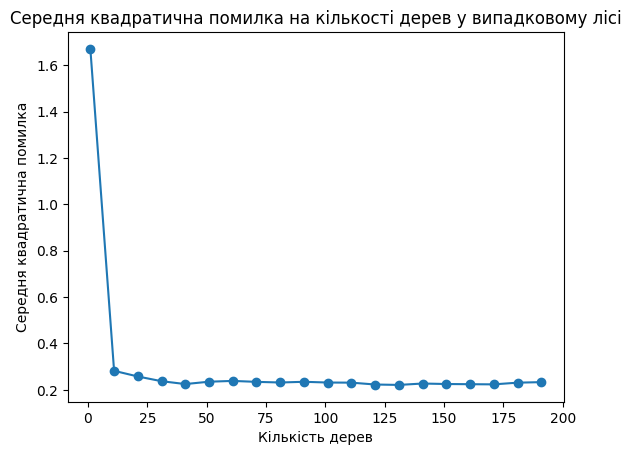

Optimal Number of Trees: 131


In [112]:
# Список для збереження значень MSE
mse_values = []

# Визначимо діапазон кількості дерев для перевірки
num_trees_range = range(1, 201, 10)

# Цикл для тренування та оцінки моделей з різною кількістю дерев
for num_trees in num_trees_range:
    forest_model = RandomForestRegressor(n_estimators=num_trees, random_state=42)
    forest_model.fit(X_train, y_train)
    forest_predictions = forest_model.predict(X_test)
    forest_mse = mean_squared_error(y_test, forest_predictions)
    mse_values.append(forest_mse)

# Знайдемо оптимальну кількість дерев за значенням MSE
optimal_num_trees = num_trees_range[mse_values.index(min(mse_values))]

# Побудуємо графік MSE від кількості дерев
plt.plot(num_trees_range, mse_values, marker='o')
plt.title('Середня квадратична помилка на кількості дерев у випадковому лісі')
plt.xlabel('Кількість дерев')
plt.ylabel('Середня квадратична помилка')
plt.show()

# Виведемо оптимальну кількість дерев
print(f'Optimal Number of Trees: {optimal_num_trees}')

In [113]:
forest_model = RandomForestRegressor(n_estimators=131, random_state=42)
forest_model.fit(X_train, y_train)
forest_predictions = forest_model.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_predictions)
print(f'Mean Squared Error for Random Forest: {forest_mse}')

Mean Squared Error for Random Forest: 0.22100730215058856


In [114]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)
gradient_boosting_predictions = gradient_boosting_model.predict(X_test)
gradient_boosting_mse = mean_squared_error(y_test, gradient_boosting_predictions)
print(f'Mean Squared Error for Gradient Boosting: {gradient_boosting_mse}')

Mean Squared Error for Gradient Boosting: 0.27633324628637623


Звіт за результатами аналізу чотирьох моделей машинного навчання для прогнозування змін відсоткового приросту індексу SPY на тестовому наборі даних має наступний вигляд:

Лінійна Регресія:
Середньоквадратична помилка (MSE): 0.2210

Дерево рішень (Decision Tree):
Середньоквадратична помилка (MSE): 0.4988

Випадковий ліс (Random Forest):
Середньоквадратична помилка (MSE): 0.2210

Градієнтний бустінг:
Середньоквадратична помилка (MSE): 0.2763

Цей аналіз вказує на те, що лінійна регресія та випадковий ліс виявилися ефективними моделями для даного завдання прогнозування. Додатково важливо розглядати інші метрики та фактори, такі як вартість навчання моделі та її інтерпретованість, при виборі оптимальної моделі для конкретного застосування

# Висновки
 1. #### Перевірка початкової ідеї брати SPY та інші акції по закриттю у п'ятницю і фіксувати прибуток у понеділок показала себе недієздатною
 2. #### Найкращий результат виявився у понеділок. Це могло виявитися будь-який випадковий день тижня, але після понеділка можна легко знайти логіку, фундамент. Що після ризику вихідніх, люди налаштовують свої фінансові ідеї та намагаються не прогаяти можливості на самому початку тижня
 3. #### SPY показав результат більш ніж в 4 рази від свого середнього.
    1. #### Не дивлячись на те, що MSFT має високу кореляцію результат трошки гірше по ринку, а GOOG показав дуже класні результати в 20 разів краще за середню та низькою волатильністю
    2. #### Інші акції себе також гарно показали, особливо AAPL та META у яких середне значення взагалі від'ємне
    3. #### А ось AMZN, ритейлер-конгломерат, ні по кореляції ні по зміні гепу від середнього значення, нам не підходиь
 4. #### Лінійна Регресія та Випадковий ліс показали найкращі значення по прогнозуванню. Градієнтний бустінг також не далеко. Вже треба перевіряти ці моделі на реальних данних,яка кожної з них вартісь та інтерпретованість.

                                                                         P.S. Ця робота є теоретичною і не є інвестиційною порадою!